In [1]:
import pickle, sys, os
import numpy as np
import pandas as pd
import prospect
import pfs_spectra_params 

from astropy.io import fits
from sedpy import observate

In [2]:
def Choi_2014(logmstar):
    return logmstar*0.11881615 - 1.0826891415131317

def Matthee_2018(logmstar, logssfr):
    return -0.282*(logmstar-10.0) + 0.290*(logssfr+logmstar) + 0.163

def est_afe(logmstar, logssfr):
    if logssfr > -10.5:
        return Matthee_2018(logmstar, logssfr)
    else:
        return Choi_2014(logmstar)
est_afe = np.vectorize(est_afe)

In [3]:
    # ---- load 3dhst catalog ---- #
    cat=pickle.load(open('../input/prospector_3dhst_bestfit_catalog.pickle', 'rb'))
    print('display first 5 objects')
    for ikey in cat.keys():
        print(ikey, cat[ikey][:5])

    mod = pfs_spectra_params.build_model(objname='test',afe_on=True)
    mod.params['nebemlineinspec'] = True
    sps = pfs_spectra_params.build_sps()
    print('finish building sps')
    # FILTERS
    # UgrizyJ, IRAC1, IRAC2
    filters = ['bessell_U']
    filters +=  ['sdss_'+filt+'0' for filt in ['g','r','i','z']]
    filters += ['uvista_y_cosmos','UDS_J']
    filters += ['IRAC_CH1','IRAC_CH2']
    ### SPECTRUM
    hdu = fits.open('../input/noise_spec_12hr.fits')
    wave_obs = hdu[1].data['WAV']
    #detector_noise = hdu[1].data['ERR']/1e-23/3631 * wave_obs**2/(3e18) # erg/s/cm^2/A

    ### Remove repeated wavelength values
    print('REMOVING REPEATED WAVELENGTH VALUES')
    _, idx = np.unique(wave_obs, return_index=True)
    wave_obs = wave_obs[idx]
    #detector_noise = detector_noise[idx]

    ### define masks
    mask = np.ones(len(wave_obs),dtype=bool)
    phot_mask = np.ones(len(filters),dtype='bool')


    obs = {'filters': []}
    for filt in filters:
        #print('loading '+filt)
        obs['filters'] += observate.load_filters([filt])
    obs['wave_effective'] = np.array([filt.wave_effective for filt in obs['filters']])
    obs['phot_mask'] = phot_mask
    if wave_obs is not None:
        obs['wavelength'] = wave_obs[mask]
        obs['mask'] = np.ones(mask.sum(),dtype=bool)
    else:
        obs['wavelength'] = None

display first 5 objects
dust1_fraction [1.24274787 1.18358962 1.21648014 0.85535957 0.82708048]
dust2 [1.30110954 1.45282801 0.25680514 0.06070061 0.45792446]
dust_index [-0.25120421  0.06470886  0.14646028 -0.72055     0.35590058]
gas_logz [ 0.11262719 -0.16669341 -0.67486781  0.2276225  -1.01314053]
logsfr_ratios_1 [0.28752652 0.13026776 0.14127212 0.03998617 0.47830477]
logsfr_ratios_2 [ 0.36074601  0.02157012 -0.07948795 -0.02777394  0.02428069]
logsfr_ratios_3 [0.00788727 0.10336385 0.23229781 0.07597261 0.08781713]
logsfr_ratios_4 [0.09498663 0.13472415 0.24671893 0.05407279 0.12071265]
logsfr_ratios_5 [-0.39796617  0.17047266 -0.04688681 -0.27787392 -0.22250321]
logsfr_ratios_6 [ 0.17108806  0.02099638 -0.11346972 -0.3261988  -0.11406414]
z [1.3049 1.7499 1.0761 1.657  0.9595]
name ['AEGIS_13' 'AEGIS_17' 'AEGIS_19' 'AEGIS_22' 'AEGIS_23']
log_stellarmass [10.66677611 10.55743587  9.51026845  9.28363582  8.38584093]
log_ssfr [5.91985838e-10 9.85640418e-10 6.02756909e-10 7.42222202

In [4]:
    theta_all_df = pd.read_csv('theta_all.csv')  
    theta_all_df = theta_all_df.reindex(columns=mod.theta_labels())

In [22]:
i = 21
obs['redshift'] = float(theta_all_df['zred'][i])
spec, photometric_fluxes, sm = mod.predict(theta =list(theta_all_df.loc[i].to_numpy()),
                                                   obs = obs,
                                                   sps = sps)

In [23]:
theta_2 = np.copy(theta_all_df.loc[i].to_numpy())
print(theta_2[10])
theta_2[10] = 0.0
spec2, photometric_fluxes2, sm2 = mod.predict(theta = theta_2,
                                                   obs = obs,
                                                   sps = sps)

0.6047810407348231


In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

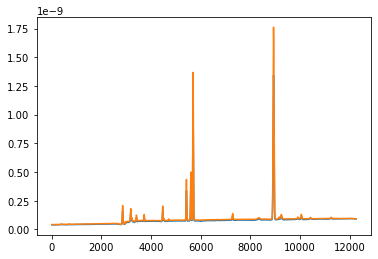

In [24]:
plt.plot(spec)
plt.plot(spec2)

In [36]:
def Matthee_2018(logmstar, logssfr):
    return -0.282*(logmstar-10.0) + 0.290*(logssfr+logmstar) + 0.163
Matthee_2018 = np.vectorize(Matthee_2018)

In [40]:
cat['log_stellarmass']+ np.log10(cat['log_ssfr'])

array([ 1.43908743,  1.55115437,  0.29041064, ..., -0.13341116,
        0.50218186,  0.02405382])

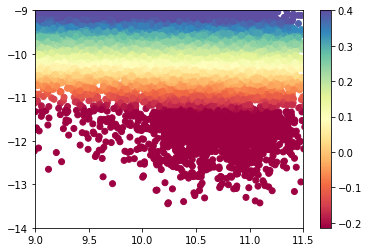

In [45]:
x, y = cat['log_stellarmass'], np.log10(cat['log_ssfr'])
c = Matthee_2018(x, y)
plt.scatter(x,y, c=c, vmax=-0.195, vmin=0.4, cmap='Spectral')
plt.xlim(9, 11.5)
plt.ylim(-14, -9)
plt.colorbar()

(-0.2, 0.9)

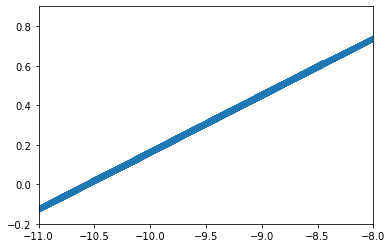

In [48]:
plt.plot(y, c)
plt.xlim(-11, -8)
plt.ylim(-0.2, 0.9)